In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm
import random
import bisect
import collections

In [2]:
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.reward import RewardBase
from amalearn.environment import EnvironmentBase
from amalearn.reward import GaussianReward
from amalearn.agent import RandomBanditAgent
from amalearn.agent import AgentBase

## Utils

In [3]:
def calculate_action_percentage(chosen_actions, window = 1000):
    result = []
    for j in tqdm(range(45)):
        temp = []
        for i in range(len(chosen_actions) - window):
            temp.append(chosen_actions[i:i+window].count(j)/window*100)
        result.append(temp)
    return result

In [4]:
def cdf(weights):
    total = sum(weights)
    result = []
    cumsum = 0
    for w in weights:
        cumsum += w
        result.append(cumsum / total)
    return result

def choice(population, weights):
    assert len(population) == len(weights)
    cdf_vals = cdf(weights)
    x = random.random()
    idx = bisect.bisect(cdf_vals, x)
    return population[idx]

In [5]:
layer_1 = [1, 2, 3]
layer_2 = [4, 5, 6, 7, 8]
layer_3 = [9, 10, 11]
all_actions = []
for i in layer_1:
    for j in layer_2:
        for k in layer_3:
            all_actions.append([0, i, j, k, 12])

def green():
    delay =  np.random.normal(3, 4)
    if delay > 0:
        return delay
    else:
        return 0

def blue():
    delay = np.random.normal(6, 3.2)
    if delay > 0:
        return delay
    else:
        return 0

def orange():
    delay = np.random.normal(3, 6.5)
    if delay > 0:
        return delay
    else:
        return 0

def node_latency(p):
    if np.random.rand() > p:
        return 0
    return 30

link_latency = {
    (0, 2): green,
    (1, 4): green,
    (1, 5): green,
    (1, 6): green,
    (3, 7): green,
    (3, 8): green,
    (4, 9): green,
    (5, 11): green,
    (6, 10): green,
    (7, 10): green,
    (7, 11): green,
    (8, 9): green,
    (0, 1): blue,
    (2, 6): blue,
    (2, 4): blue,
    (2, 8): blue,
    (3, 4): blue,
    (3, 5): blue,
    (3, 6): blue,
    (4, 10): blue,
    (5, 10): blue,
    (6, 9): blue,
    (9, 12): blue,
    (11, 12): blue,
    (0, 3): orange,
    (1, 7): orange,
    (1, 8): orange,
    (2, 5): orange,
    (2, 7): orange,
    (4, 11): orange,
    (5, 9): orange,
    (6, 11): orange,
    (7, 9): orange,
    (8, 10): orange,
    (8, 11): orange,
    (10, 12): orange,
}

node_latecy_map = {
    1: 0.1,
    2: 0.06,
    3: 0.15,
    4: 0.5,
    5: 0.1,
    6: 0.15,
    7: 0.65,
    8: 0.12,
    9: 0.2,
    10: 0.05,
    11: 0.45 
}


In [6]:
def calc_delay(path):
    delay = 0
    for i in range(len(path)-2):
        delay += node_latency(node_latecy_map[path[i+1]])
        delay += link_latency[(path[i], path[i+1])]()
    return delay

## Class Definitions

In [7]:
class MyQ3Reward(RewardBase):
    def __init__(self):
        super(MyQ3Reward, self).__init__()
    
    def get_reward(self, delay):
        return (100 - delay) / 10

In [8]:
class myQ3Environment(EnvironmentBase):
    def __init__(self, reward, num_of_actions, episode_max_length, id, container=None):
        state_space = gym.spaces.Discrete(1)
        action_space = gym.spaces.Discrete(num_of_actions)
        super(myQ3Environment, self).__init__(action_space, state_space, id, container)
        self.rewards = reward
        self.episode_max_length = episode_max_length
        self.state = {
            'length': 0,
            'last_action': None
        }

    def calculate_reward(self, action):
        path = all_actions[action]
        delay = calc_delay(path)
        return self.rewards.get_reward(delay)
    
    def terminated(self):
        return self.state['length'] >= self.episode_max_length

    def observe(self):
        return {}

    def available_actions(self):
        return self.action_space.n

    def next_state(self, action):
        self.state['length'] += 1
        self.state['last_action'] = action

    def reset(self):
        self.state['length'] = 0
        self.state['last_action'] = None

    def render(self, mode='human'):
        print('{}:\taction={}'.format(self.state['length'], self.state['last_action']))

    def close(self):
        return

In [9]:
class myAgent(AgentBase):
    def __init__(self, id, num_of_actions, environment):
        super(myAgent, self).__init__(id, environment)
        self.trial = 0
        self.prefrences = np.zeros(num_of_actions)
        self.mean_reward = 0
        
    def hemographic_learning_rate(self, x):
        return 100/((0.005)*x+400)
        
    def get_actions(self):
        return self.actions, self.action_num, self.rev
    
    def cal_total_prefrence(self):
        tot = 0
        for h in self.prefrences:
            tot += np.exp(h)
        return tot
    
    def take_action(self) -> (object, float, bool, object):
        self.trial += 1
        
        # 1. choose action
        available_actions = self.environment.available_actions()
        total_prefrence = self.cal_total_prefrence()
        actions_prefrences = [np.exp(h)/total_prefrence for h in self.prefrences]
        action = choice(range(len(actions_prefrences)), actions_prefrences)
        
        # 2. DO A_t and get R_t
        obs, reward, fin, info = self.environment.step(action)
        
        learning_rate = self.hemographic_learning_rate(self.trial)
        learning_rate = 0.006
        self.prefrences[action] = \
        self.prefrences[action] + learning_rate * (reward - self.mean_reward) * (1 - actions_prefrences[action])
        for i in range(len(self.prefrences)):
            if i != action:
                self.prefrences[i] = \
                self.prefrences[i] - learning_rate * (reward - self.mean_reward) * (actions_prefrences[i])
                
        self.mean_reward = (self.mean_reward * (self.trial - 1) + reward) / self.trial
        
        if fin: print('-----Terminated-----')
        return reward, action

In [10]:
class eGreedyAgent(AgentBase):
    def __init__(self, id, num_of_actions, environment):
        super(eGreedyAgent, self).__init__(id, environment)
        self.trial = 0
        self.actions = np.zeros(num_of_actions)
        self.action_num = np.ones(num_of_actions)
        self.rev = np.zeros(num_of_actions)
        
    def hemographic_learning_rate(self, x):
        return 100/((0.005)*x+400)
    
    def get_epsilo(self, x):
        return (2 ** (1 - 0.0001 * x)) / 2
    
    def get_action(self, available_actions, epsilon):
        if self.trial == 1:
            return np.random.randint(available_actions)
        if np.random.rand() > epsilon:
            return np.argmax(self.actions)
        else:
            return np.random.randint(available_actions)
        
    def get_actions(self):
        return self.actions, self.action_num, self.rev
    
    def take_action(self) -> (object, float, bool, object):
        
        self.trial += 1
        epsilon = self.get_epsilo(self.trial)
        
        available_actions = self.environment.available_actions()
        action = self.get_action(available_actions, epsilon)
        self.action_num[action] += 1
        
        obs, reward, fin, info = self.environment.step(action)
        
        learning_rate = 1/(1+self.action_num[action])
        self.rev[action] = self.rev[action] + reward
        self.actions[action] = self.actions[action] + learning_rate * (reward - self.actions[action])

        if fin: print('-----Terminated-----')
        return reward, fin, action

## Learn

### e-Greedy Agent

In [11]:
rewards = MyQ3Reward()
environment = myQ3Environment(rewards, 45, 80000, '1')
egreedyAgent = eGreedyAgent('2', 45, environment)

In [12]:
result_e_greedy_agent = []
for step in range(80000):
    result_e_greedy_agent.append(egreedyAgent.take_action())

-----Terminated-----


In [13]:
chosen_actions = [i[2] for i in result_e_greedy_agent]
ap_e_greredy = calculate_action_percentage(chosen_actions, window = 1000)

100%|██████████| 45/45 [09:18<00:00, 12.42s/it]


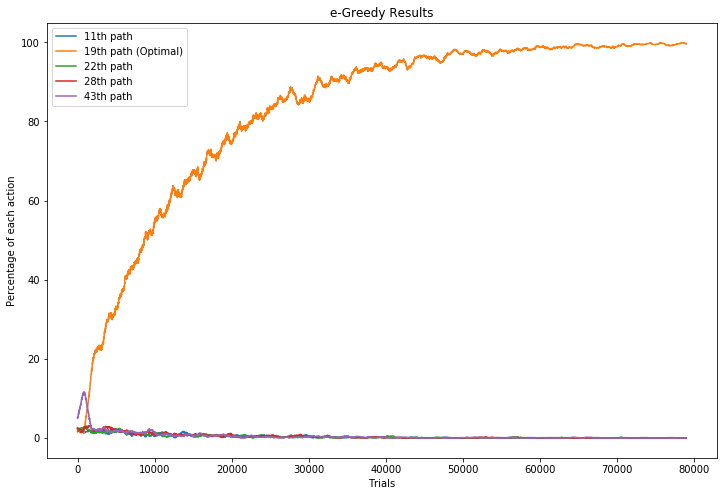

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(ap_e_greredy[11])), ap_e_greredy[11], label= str(11) + "th path")
plt.plot(range(len(ap_e_greredy[19])), ap_e_greredy[19], label= str(19) + "th path (Optimal)")
plt.plot(range(len(ap_e_greredy[22])), ap_e_greredy[22], label= str(22) + "th path")
plt.plot(range(len(ap_e_greredy[28])), ap_e_greredy[28], label= str(28) + "th path")
plt.plot(range(len(ap_e_greredy[43])), ap_e_greredy[43], label= str(43) + "th path")

plt.legend(loc="upper left")
plt.title('e-Greedy Results')
plt.ylabel('Percentage of each action')
plt.xlabel('Trials')
plt.show()

### Gradient Acent Agent

In [15]:
rewards = MyQ3Reward()
environment = myQ3Environment(rewards, 45, 80000, '1')
agent = myAgent('2', 45, environment)

In [16]:
result_1 = []
for step in range(80000):
    result_1.append(agent.take_action())

-----Terminated-----


In [17]:
chosen_actions = [i[1] for i in result_1]
ap = calculate_action_percentage(chosen_actions, window = 1000)

100%|██████████| 45/45 [01:05<00:00,  1.45s/it]


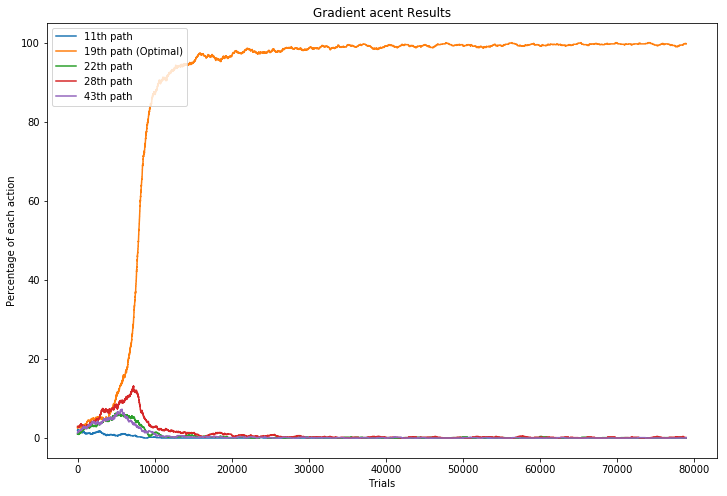

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(ap[11])), ap[11], label= str(11) + "th path")
plt.plot(range(len(ap[19])), ap[19], label= str(19) + "th path (Optimal)")
plt.plot(range(len(ap[22])), ap[22], label= str(22) + "th path")
plt.plot(range(len(ap[28])), ap[28], label= str(28) + "th path")
plt.plot(range(len(ap[43])), ap[43], label= str(43) + "th path")

plt.legend(loc="upper left")
plt.title('Gradient acent Results')
plt.ylabel('Percentage of each action')
plt.xlabel('Trials')
plt.show()

lets get some samples from each action's latency to aproximate which one is better

Text(0.5, 1.0, 'Mean Latency')

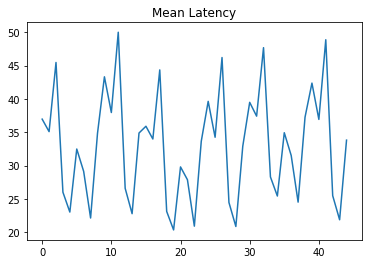

In [19]:
mean_reward_actions = [np.array([calc_delay(j) for i in range(100000)]).mean() for j in all_actions]
plt.plot(range(len(mean_reward_actions)), mean_reward_actions)
plt.title('Mean Latency')